In [154]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt 
from scipy.special import expit as logistic

from jupyterthemes import jtplot
jtplot.style()

In [169]:
df = pd.read_csv(
    '/Users/Alby/Desktop/rethinking statistics/Rethinking/Data/reedfrogs.csv', sep = ',')

print(df.columns)
df.head(5).append(df.tail(5))

Index(['density', 'pred', 'size', 'surv', 'propsurv'], dtype='object')


,density,pred,size,surv,propsurv
0,10,no,big,9,0.900000
1,10,no,big,10,1.000000
2,10,no,big,7,0.700000
3,10,no,big,10,1.000000
4,10,no,small,9,0.900000
43,35,pred,big,14,0.400000
44,35,pred,small,22,0.628571
45,35,pred,small,12,0.342857
46,35,pred,small,31,0.885714
47,35,pred,small,17,0.485714


In [170]:
def indexer(row) : 
    '''assign numbers to pred labels'''
    if row['pred'] == 'no' : 
        val = 0
    elif row['pred'] == 'pred' : 
        val = 1
    else : 
        val = 'error'
    return val
 
df.loc[:, 'predator'] = df.apply(indexer, axis = 1)

def size_indexer(row) :
    '''assign numbers to size labels'''
    if row['size'] == 'big' : 
        val = 1
    elif row['size'] == 'small' : 
        val = 0
    return val

df.loc[:, 'sizer'] = df.apply(size_indexer, axis = 1) 
#print(df.predator) ; print(df.sizer)

In [171]:
tank = np.arange(df.shape[0])
size = df.sizer.values
predator = df.predator.values

tank

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

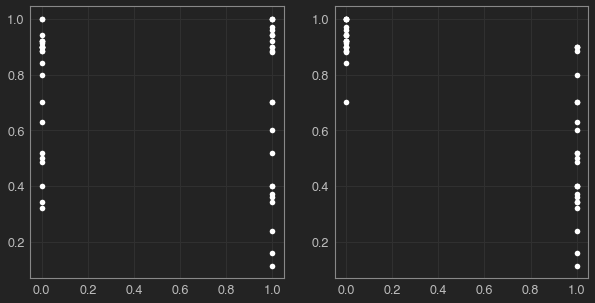

In [172]:
_, ax = plt.subplots(1, 2, figsize = (10, 5)) 
ax[0].plot(df.sizer, df.propsurv, 'o', color = 'w') 
ax[1].plot(df.predator, df.propsurv, 'o', color = 'w')

In [78]:
varnames = ['alpha_bar', 'sigma_alpha', 'b_pred', 'b_size']

In [79]:
with pm.Model() as frog_man : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_pred = pm.Normal('b_pred', mu = .5, sigma = 1) 
    b_size = pm.Normal('b_size', mu = 0, sigma = 3) 
    
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    
    p = pm.math.invlogit(alpha_tank[tank] + b_pred * predator + b_size * size)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = varnames)

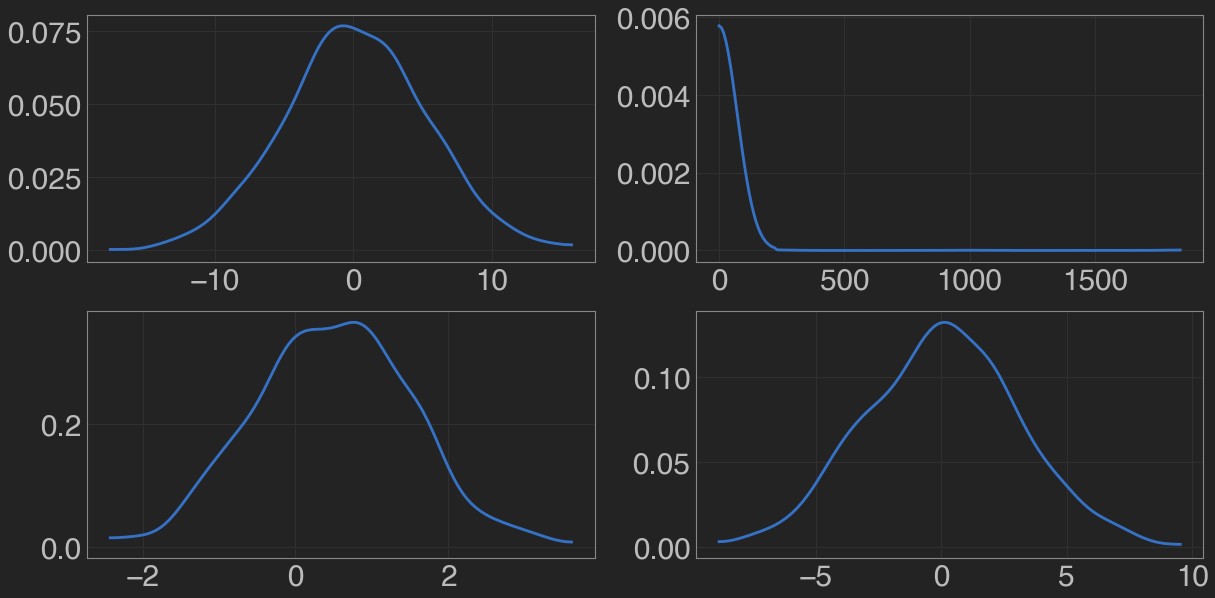

In [80]:
__, ax = plt.subplots(2, 2, figsize = (20, 10))

for i, axis in zip(varnames, ax.flat) : 
    az.plot_kde(prior[i], ax = axis)

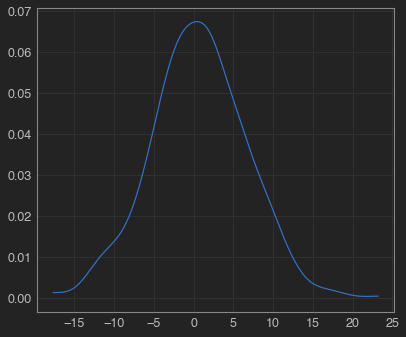

In [81]:
pr = 1
sz = 1
az.plot_kde(prior['alpha_bar'] + prior['b_pred'] * pr + prior['b_size'] * sz)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tank, b_size, b_pred, sigma_alpha, alpha_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:11<00:00, 1453.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23103b50>,
      dtype=object)

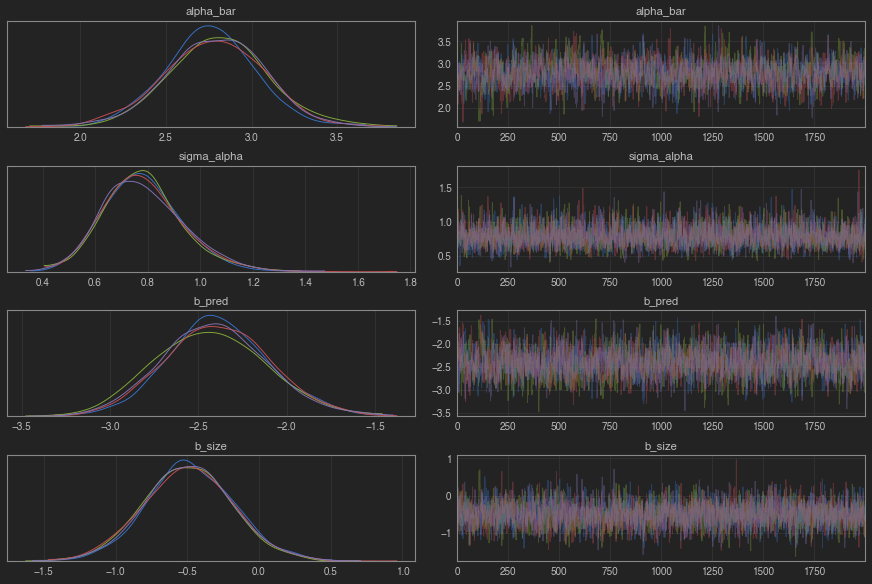

In [84]:
with frog_man : 
    trace_1 = pm.sample(2000, tune = 2000) 
    
az.plot_trace(trace_1, var_names = varnames)

In [88]:
az.summary(trace_1, round_to = 2, var_names = varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,2.78,0.28,2.23,3.31,0.01,0.01,1315.41,1312.81,1318.30,2434.08,1.0
sigma_alpha,0.78,0.15,0.52,1.07,0.00,0.00,2430.17,2430.17,2314.83,2500.10,1.0
b_pred,-2.41,0.30,-2.97,-1.83,0.01,0.01,1694.78,1690.31,1691.75,2904.94,1.0
b_size,-0.49,0.30,-1.08,0.07,0.01,0.00,2244.15,2244.15,2247.90,3903.94,1.0


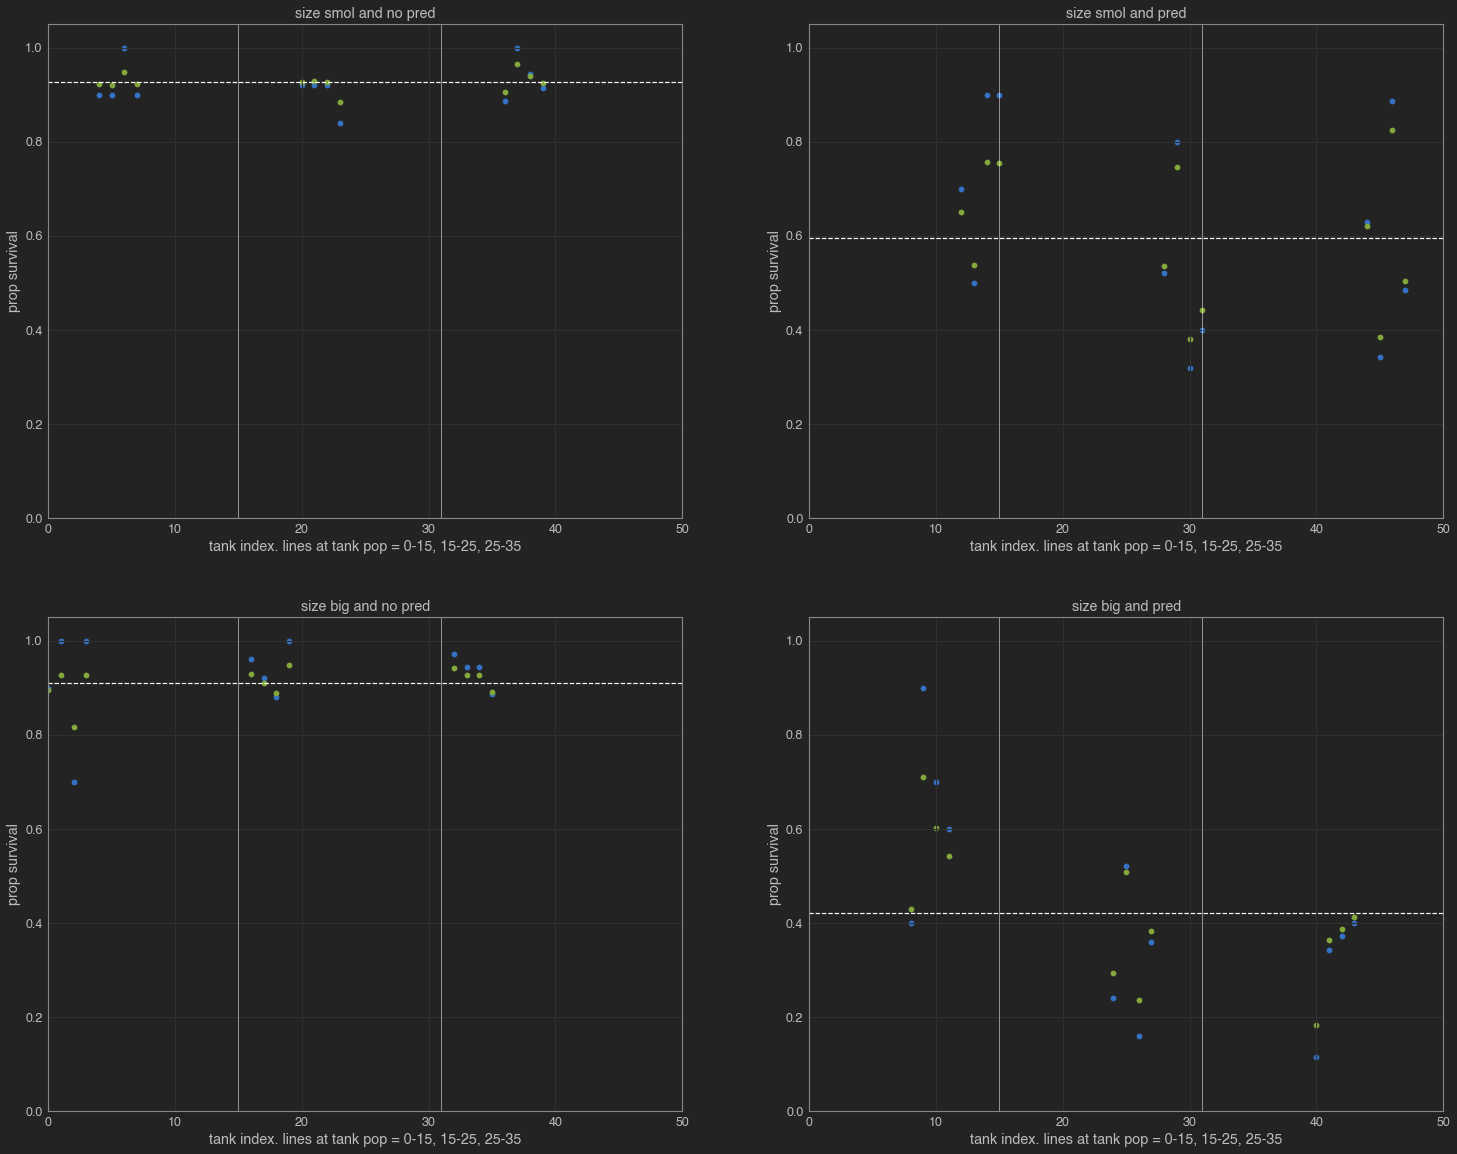

In [198]:
__, axs = plt.subplots(2, 2, figsize = (25 , 20))
size_pred_seq = [[0,0], [0,1], [1,0], [1,1]]

tanks = np.arange(df.shape[0])
trace_df = pm.trace_to_dataframe(trace_1) 

for s, ax in zip(size_pred_seq, axs.flat):
    '''
    loop over each axis and pred/size combination. grab relevant data rows and push thru trace
    take the mean and plot. add in lines to separate btwn between tank sizes 
    '''
    data_rows = df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])]
    ax.scatter(data_rows.index, data_rows.propsurv.values)
    trace_tank_index = (data_rows.index + 3) #offset by three since the trace has other params before it gets to the tanks
    mu_raw = logistic(trace_df.iloc[:, trace_tank_index].values + (trace_df['b_size']*s[0])[:, None] \
                      + (trace_df['b_pred'] * s[1])[:, None])
    mu = mu_raw.mean(0) 
    ax.scatter(data_rows.index.values, mu)
    ax.hlines(mu.mean(), -1, 50, color = 'w', linestyles='--')
    lines = [df.loc[df['density'] == 10].index.values.max(),
             df.loc[df['density'] == 25].index.values.max()]
    ax.vlines(lines, -1, 2, color = 'w', lw = .5)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 1.05)
    title = []
    if s[0] == 0 :
        title.append('size smol ')
    else : 
        title.append('size big ')
    if s[1] == 0 : 
        title.append('and no pred')
    else :
        title.append('and pred')
    ax.set_title(title[0] + title[1])
    ax.set_xlabel('tank index. lines at tank pop = 0-15, 15-25, 25-35')
    ax.set_ylabel('prop survival')

###### note how nicely the model shrinks the crazy low tank on bottom left–it knows that it was a fluke to have such a condition with such a low surv rate. It recognizes that size doesn't matter so much. 

#### scratchwork for the graph above

In [103]:
df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].shape[0]

12

In [107]:
df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].propsurv.values

array([0.9       , 0.9       , 1.        , 0.9       , 0.92      ,
       0.92      , 0.92      , 0.84      , 0.88571429, 1.        ,
       0.94285714, 0.91428571])

In [121]:
for s in size_pred_seq : 
    print(s[0]) 
    print(s[1])

0
0
0
1
1
0
1
1


In [122]:
df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].density.index

Int64Index([8, 9, 10, 11, 24, 25, 26, 27, 40, 41, 42, 43], dtype='int64')

In [126]:
df.iloc[df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].index].density.values

array([10, 10, 10, 10, 25, 25, 25, 25, 35, 35, 35, 35])

In [134]:
df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].index

Int64Index([8, 9, 10, 11, 24, 25, 26, 27, 40, 41, 42, 43], dtype='int64')

In [138]:
pm.trace_to_dataframe(trace_1).iloc[:, df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])].index + 3].values

array([[2.41920391, 3.47126839, 2.98406341, ..., 2.29392034, 1.93145521,
        2.18349549],
       [2.1341607 , 3.38066119, 3.16668138, ..., 2.24872674, 3.19208377,
        2.79689772],
       [3.25756396, 4.89199932, 3.60393678, ..., 2.58130068, 1.95902601,
        2.30752127],
       ...,
       [2.3154743 , 3.7801911 , 3.26205909, ..., 2.78249717, 2.57870058,
        2.71190852],
       [1.93454253, 3.38636117, 3.72905167, ..., 2.46265389, 2.64019359,
        2.59638868],
       [2.64774943, 3.60474189, 4.35710311, ..., 2.00509263, 2.20890787,
        2.47235796]])

In [141]:
pm.trace_to_dataframe(trace_1)

,alpha_bar,b_pred,b_size,alpha_tank__0,alpha_tank__1,alpha_tank__2,alpha_tank__3,alpha_tank__4,alpha_tank__5,alpha_tank__6,...,alpha_tank__39,alpha_tank__40,alpha_tank__41,alpha_tank__42,alpha_tank__43,alpha_tank__44,alpha_tank__45,alpha_tank__46,alpha_tank__47,sigma_alpha
0,2.760265,-2.327504,-0.411937,3.215659,3.080670,1.998623,3.244487,3.179306,2.216319,2.699113,...,2.505860,1.474048,2.293920,1.931455,2.183495,2.426227,1.737887,3.849501,2.563558,0.617125
1,2.722579,-2.306893,-0.686766,1.854607,3.295758,1.514242,2.767122,1.789816,2.268875,2.563648,...,3.471346,1.165695,2.248727,3.192084,2.796898,3.345919,1.644030,4.389026,2.180664,0.831374
2,2.956862,-2.339415,-0.754269,5.031601,2.385105,2.743375,3.843144,3.341733,3.688608,4.402998,...,1.946362,1.917315,2.581301,1.959026,2.307521,2.381736,2.002250,3.865518,2.292419,0.992582
3,2.833624,-2.229251,-0.648675,2.001080,5.174972,1.815856,3.008816,1.641802,2.565823,3.432738,...,3.261989,1.096183,2.197896,2.476942,2.878228,3.452817,1.801801,4.384132,2.419106,1.118075
4,2.723541,-2.507473,-0.594559,2.467353,4.908735,2.595598,2.809899,2.029745,1.450377,3.075801,...,3.029906,2.259051,2.351212,1.996089,2.569278,3.382195,1.512591,4.106600,2.495600,0.639222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2.801038,-2.276865,-0.549144,2.552202,4.760973,2.120028,1.980363,2.446664,2.369729,3.381977,...,2.041660,1.734404,1.845998,2.293424,2.957654,2.668928,1.771902,3.549565,1.811890,0.774808
7996,2.702076,-2.492351,-0.614466,3.333050,1.923272,2.338506,4.907482,2.862210,2.945145,2.869691,...,3.171809,1.139961,2.816295,2.410484,2.906200,2.791873,1.780703,4.129619,2.702106,0.714343
7997,3.014600,-2.544414,-0.673378,3.376649,2.174413,1.734763,3.896563,2.454738,2.162214,3.153510,...,2.723911,1.906724,2.782497,2.578701,2.711909,3.189284,1.852865,4.382474,2.316054,0.957645
7998,2.882327,-2.509950,-0.608658,3.380117,3.307862,2.652124,3.751692,2.895590,2.622666,3.280361,...,2.486278,2.228779,2.462654,2.640194,2.596389,3.130327,1.982433,4.745980,2.383747,0.744864


In [157]:
logistic(trace_df.iloc[:, trace_tank_index].values + (trace_df['b_size']*s[0])[:, None] + (trace_df['b_pred'] * s[1])[:, None]).mean(0).shape

(12,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tank, b_pred, sigma_alpha, alpha_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:09<00:00, 1713.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,2.524,0.244,2.068,2.981,0.007,0.005,1237.0,1237.0,1233.0,2909.0,1.0
sigma_alpha,0.829,0.144,0.565,1.100,0.003,0.002,2212.0,2212.0,2128.0,3272.0,1.0
b_pred,-2.383,0.311,-2.940,-1.766,0.010,0.007,1067.0,1067.0,1066.0,2458.0,1.0


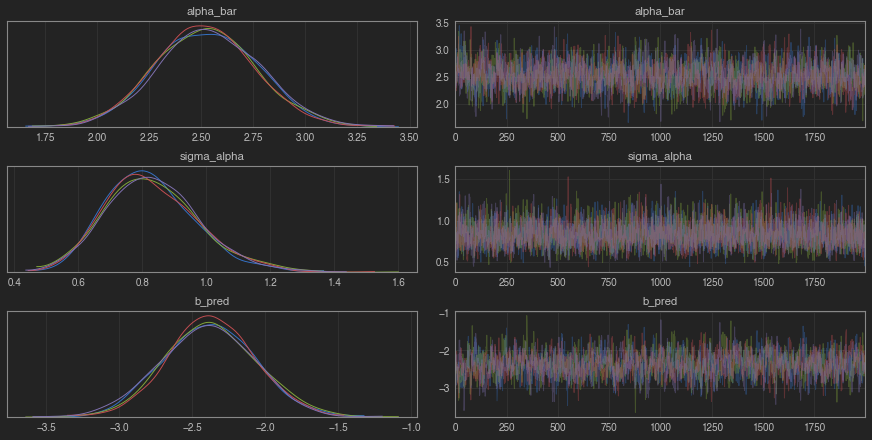

In [209]:
with pm.Model() as frog_man_pred : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_pred = pm.Normal('b_pred', mu = .5, sigma = 1) 
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    p = pm.math.invlogit(alpha_tank[tank] + b_pred * predator)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred'])
    trace_2 = pm.sample(2000, tune = 2000)
az.plot_trace(trace_2, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred']) 
az.summary(trace_2, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tank, b_size, sigma_alpha, alpha_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:10<00:00, 1476.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,1.508,0.351,0.856,2.170,0.007,0.005,2212.0,2201.0,2217.0,4435.0,1.0
sigma_alpha,1.627,0.222,1.224,2.044,0.003,0.002,6621.0,6568.0,6655.0,6352.0,1.0
b_size,-0.255,0.473,-1.107,0.666,0.013,0.009,1420.0,1420.0,1416.0,2503.0,1.0


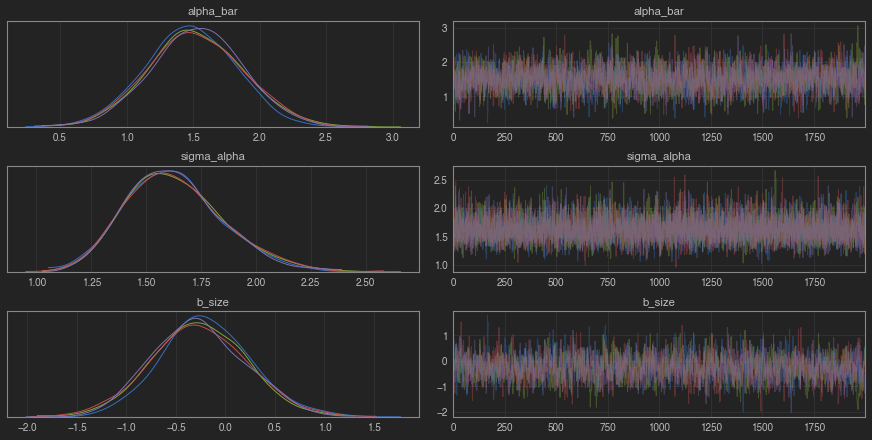

In [208]:
with pm.Model() as frog_man_size : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_size = pm.Normal('b_size', mu = .5, sigma = 1) 
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    p = pm.math.invlogit(alpha_tank[tank] +  b_size * size)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = ['alpha_bar', 'sigma_alpha', 'b_size'])
    trace_3 = pm.sample(2000, tune = 2000)
az.plot_trace(trace_3, var_names = ['alpha_bar', 'sigma_alpha', 'b_size']) 
az.summary(trace_3, var_names = ['alpha_bar', 'sigma_alpha', 'b_size'])

In [212]:
comparison = az.compare({'bigg model' : trace_1,
                        'pred model' : trace_2, 
                        'size model' : trace_3})

comparison

/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated s

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
bigg model,0,-107.235,26.4584,0,0.504715,5.06214,0,True,log
pred model,1,-107.553,27.2665,0.317414,0.411302,5.47464,1.71076,True,log
size model,2,-111.888,32.7806,4.65307,0.0839826,4.1898,3.34937,True,log


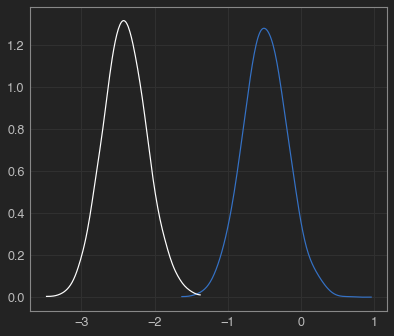

In [214]:
az.plot_kde(trace_1['b_size'])
az.plot_kde(trace_1['b_pred'], plot_kwargs = {'color' : 'w'})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b236c10>],
      dtype=object)

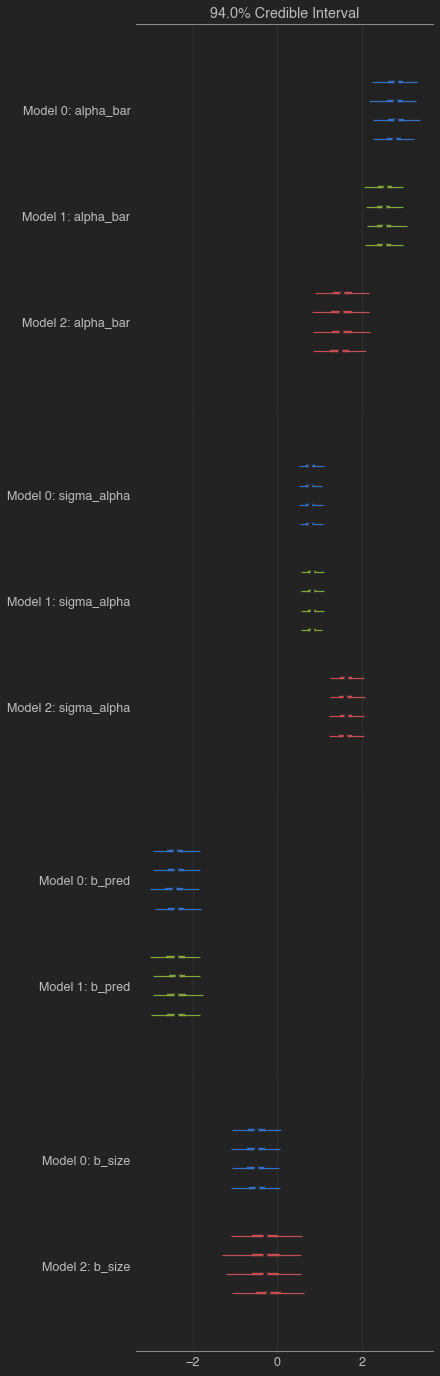

In [211]:
traces = [trace_1, trace_2, trace_3]
az.plot_forest(traces, var_names = varnames)

### these results tend to indicate that the size of the tank isn't really a relevant factor  but predator pop is: in particular, pay attention to the similarity in WAIC weights in the comparison plot, the similarity/dissimilarity between grand means in the forest plot, the tiny  difference in the graphs of the first model with varying size values, and the tendency for b_size to stay at zero in the models. Moreover, peep the mf kde plot of b_pred and b_size. Big  difference in relative importance

In [219]:
with pm.Model() as frogman_cauchy : 
    b = pm.HalfCauchy('b', 1)
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 1)
    alpha = pm.Cauchy('alpha', alpha = alpha_bar, beta = b, shape = len(tank))
    p = pm.math.invlogit(alpha[tank])
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    trace_4 = pm.sample(2000, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, alpha_bar, b]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [01:02<00:00, 254.84draws/s]
The acceptance probability does not match the target. It is 0.8794076157802178, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9152805116775309, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4747319557435343, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a244cec50>,
      dtype=object)

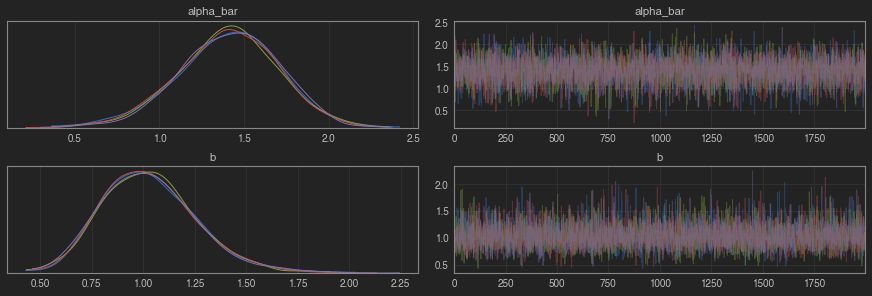

In [222]:
az.plot_trace(trace_4, var_names = ['alpha_bar', 'b'])

100%|██████████| 1000/1000 [00:00<00:00, 1461.56it/s]


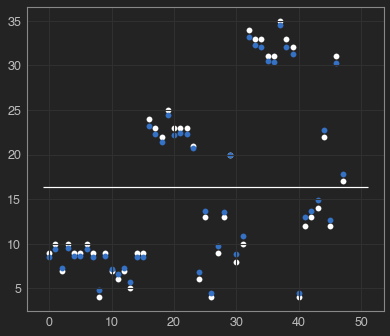

In [238]:
post = pm.sample_posterior_predictive(trace_4, 1000, frogman_cauchy)

_, ax2 = plt.subplots() 
ax2.scatter(df.index, df.surv, color = 'w')
ax2.scatter(df.index, post['surv'].mean(0) )
ax2.hlines(df.surv.mean(), -1, 51, color = 'w')

#so for some reason this shit seems to be shrinking way too little... probably the Cauchy prior

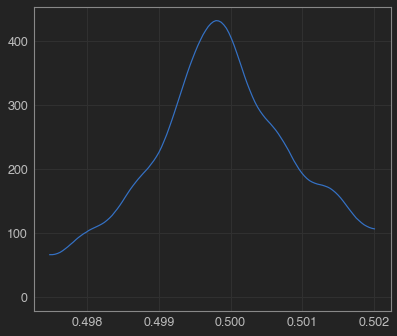

In [243]:
with frogman_cauchy : 
    priors = pm.sample_prior_predictive(100000)
    
az.plot_kde(logistic(priors['alpha']).mean(0))

##### so it looks like the wide uncertainty in the cauchy prior means that the model doesn't effectively regularize leading to overfitting

In [224]:
nu_compare = comparison = az.compare({'bigg model' : trace_1,
                        'pred model' : trace_2, 
                        'size model' : trace_3, 
                        'cauchy model' : trace_4})

nu_compare

/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated s

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
bigg model,0,-107.235,26.4584,0,0.502602,5.11256,0,True,log
pred model,1,-107.553,27.2665,0.317414,0.420752,5.49373,1.71076,True,log
size model,2,-111.888,32.7806,4.65307,0.0617707,4.21834,3.34937,True,log
cauchy model,3,-115.179,36.5083,7.94404,0.0148748,5.03391,4.21509,True,log
